In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.getcwd()
os.chdir( "C:/Users/Miray/Desktop")
os.getcwd()
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from scipy import stats
import scipy.stats as st

from warnings import filterwarnings
filterwarnings('ignore')

**Bu notebook'ta ilk ödevlerden biri olan ROC Curve ve Logistic Classificatin sonuçları bulunmaktadır. Dummy variable dönüşümü yapılmıştır.**
Split'siz olarak ve split olarak model incelenmiştir.

In [2]:
finans=pd.read_csv("finans.csv")

In [3]:
hq=finans.copy()
df=hq.dropna()
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2018 entries, 153 to 3549
Data columns (total 13 columns):
bad        2018 non-null int64
loan       2018 non-null int64
mortdue    2018 non-null float64
value      2018 non-null float64
reason     2018 non-null object
job        2018 non-null object
yoj        2018 non-null float64
derog      2018 non-null float64
delinq     2018 non-null float64
clage      2018 non-null float64
ninq       2018 non-null float64
clno       2018 non-null float64
debtinc    2018 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 220.7+ KB


,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
153,0,18200,94727.0,136877.0,DebtCon,Mgr,15.0,0.0,0.0,168.96,2.0,26.0,36.056
154,0,21700,79240.0,96784.0,DebtCon,Mgr,5.0,0.0,0.0,64.51,6.0,24.0,38.079
155,0,34100,241931.0,36486.0,DebtCon,Mgr,1.0,0.0,2.0,196.01,3.0,50.0,42.459
156,0,8400,62989.0,76718.0,HomeImp,Mgr,3.0,0.0,2.0,131.47,0.0,22.0,29.200
157,0,17400,25859.0,43684.0,DebtCon,Mgr,16.0,1.0,0.0,95.36,1.0,17.0,27.108


In [4]:
df.isnull().values.any()

False

In [5]:
kat_finans=df.select_dtypes(include=["object"])
kat_finans.head()

,reason,job
153,DebtCon,Mgr
154,DebtCon,Mgr
155,DebtCon,Mgr
156,HomeImp,Mgr
157,DebtCon,Mgr


In [6]:
kat_finans.reason.unique()

array(['DebtCon', 'HomeImp'], dtype=object)

In [7]:
kat_finans.reason.value_counts()

DebtCon    1428
HomeImp     590
Name: reason, dtype: int64

In [8]:
kat_finans.job.unique()

array(['Mgr', 'Office', 'Other', 'ProfEx', 'Sales', 'Self'], dtype=object)

In [9]:
dms=pd.get_dummies(df[['reason','job']])
dms.head()

,reason_DebtCon,reason_HomeImp,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self
153,1,0,1,0,0,0,0,0
154,1,0,1,0,0,0,0,0
155,1,0,1,0,0,0,0,0
156,0,1,1,0,0,0,0,0
157,1,0,1,0,0,0,0,0


In [10]:
y=df["bad"]
X_=df.drop(["bad","reason","job"],axis=1).astype("float64")
# X'in alacağı değerlerden kategorikleri ve hedef değişkeni sildik.
X_.head()

,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc
153,18200.0,94727.0,136877.0,15.0,0.0,0.0,168.96,2.0,26.0,36.056
154,21700.0,79240.0,96784.0,5.0,0.0,0.0,64.51,6.0,24.0,38.079
155,34100.0,241931.0,36486.0,1.0,0.0,2.0,196.01,3.0,50.0,42.459
156,8400.0,62989.0,76718.0,3.0,0.0,2.0,131.47,0.0,22.0,29.200
157,17400.0,25859.0,43684.0,16.0,1.0,0.0,95.36,1.0,17.0,27.108


In [11]:
X=pd.concat([X_,dms[["reason_HomeImp","job_Mgr","job_Office","job_Other","job_ProfEx","job_Sales","job_Self"]]],axis=1) #dummy haliyle concat yaparak bağımsız değişken dataframe'i oluşturduk.
X.head()

,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc,reason_HomeImp,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self
153,18200.0,94727.0,136877.0,15.0,0.0,0.0,168.96,2.0,26.0,36.056,0,1,0,0,0,0,0
154,21700.0,79240.0,96784.0,5.0,0.0,0.0,64.51,6.0,24.0,38.079,0,1,0,0,0,0,0
155,34100.0,241931.0,36486.0,1.0,0.0,2.0,196.01,3.0,50.0,42.459,0,1,0,0,0,0,0
156,8400.0,62989.0,76718.0,3.0,0.0,2.0,131.47,0.0,22.0,29.200,1,1,0,0,0,0,0
157,17400.0,25859.0,43684.0,16.0,1.0,0.0,95.36,1.0,17.0,27.108,0,1,0,0,0,0,0


In [12]:
#Lojistik Regresyon

In [13]:
#Öncelikle bağımlı değişkenimizi inceleyelim. 

In [14]:
df["bad"].value_counts() #0'lar iyi müşteri ve 1'ler kötü müşteri. Henüz hangisine odaklanacağıma karar vermedim.

0    1840
1     178
Name: bad, dtype: int64

In [15]:
#stats.model

In [16]:
loj=sm.Logit(y,X)
loj_model=loj.fit()
loj_model.summary()

Optimization terminated successfully.
         Current function value: 0.228362
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    bad   No. Observations:                 2018
Model:                          Logit   Df Residuals:                     2001
Method:                           MLE   Df Model:                           16
Date:                Sun, 23 Aug 2020   Pseudo R-squ.:                  0.2346
Time:                        12:51:44   Log-Likelihood:                -460.84
converged:                       True   LL-Null:                       -602.11
Covariance Type:            nonrobust   LLR p-value:                 1.039e-50
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
loan            -1.73e-05   1.05e-05     -1.640      0.101    -3.8e-05    3.37e-06
mortdue        -4.777e-06   4.76e-06     -1.004      0.315   -1.41e-05    4.55e-06
value           4.089e-06   4.06e-06      1.006      0.314   -3.87e-06    1.21e-05
yoj               -0.0109      0.013     -0.854      0.393      -0.036       0.014
derog              0.5708      0.130      4.382      0.000       0.315       0.826
delinq             0.7985      0.095      8.448      0.000       0.613       0.984
clage             -0.0046      0.001     -3.354      0.001      -0.007      -0.002
ninq               0.1119      0.049      2.303      0.021       0.017       0.207
clno              -0.0286      0.011     -2.627      0.009      -0.050      -0.007
debtinc            0.1143      0.014      8.222      0.000       0.087       0.142
reason_HomeImp    -0.0655      0.205     -0.319      0.750      -0.468       0.337
job_Mgr           -5.2660      0.615     -8.559      0.000      -6.472      -4.060
job_Office        -5.8654      0.631     -9.301      0.000      -7.101      -4.629
job_Other         -5.3199      0.567     -9.387      0.000      -6.431      -4.209
job_ProfEx        -5.3315      0.600     -8.888      0.000      -6.507      -4.156
job_Sales         -4.0426      0.774     -5.222      0.000      -5.560      -2.525
job_Self          -4.5908      0.796     -5.764      0.000      -6.152      -3.030
==================================================================================
"""

In [17]:
from sklearn.linear_model import LogisticRegression
loj=LogisticRegression(solver="liblinear")
loj_model=loj.fit(X,y)
loj_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
loj_model.intercept_ #modelin sabiti

array([-0.00026794])

In [19]:
loj_model.coef_ #modelin katsayıları

array([[-2.67871942e-05, -4.06620508e-06, -1.46642679e-06,
        -2.60005677e-03,  7.75034513e-04,  1.36265881e-03,
        -8.93066177e-03,  6.00707297e-04, -2.31086476e-03,
         5.32609455e-03, -8.47461296e-05,  3.03820382e-06,
        -1.52271413e-04, -1.23831618e-04, -8.93770387e-05,
         4.28822096e-05,  5.16178780e-05]])

In [20]:
#Tahmin ve model tuning

In [21]:
y_pred=loj_model.predict(X) #kuralan model üzerinden tahmin edilen y değerleri

In [22]:
confusion_matrix(y,y_pred) 
#gerçek y değerleri ve modelin tahmin ettiği y değerleri sonucu.0'ları yani iyi müşterileri gayet iyi sınıflandırmış.

array([[1840,    0],
       [ 178,    0]], dtype=int64)

In [23]:
accuracy_score(y,y_pred) 
#model'de iyi müşterileri yakalamak istiyorsam modelim iyi müşterileri yakalmakta gayet iyi. 0.91 oranında doğru sınıflandırmış

0.9117938553022795

In [24]:
print(classification_report(y,y_pred)) #modelin 0'ları yakalamadaki gücü recall ve f score'lar dikkate alındığında gayet yüksek.

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1840
           1       0.00      0.00      0.00       178

    accuracy                           0.91      2018
   macro avg       0.46      0.50      0.48      2018
weighted avg       0.83      0.91      0.87      2018



In [25]:
loj_model.predict(X)[0:10] #ilk 10 değeri iyi müşteri olarak tahmin etmiştir.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [26]:
y[0:10]

153    0
154    0
155    0
156    0
157    0
158    0
159    0
160    0
161    0
162    0
Name: bad, dtype: int64

In [27]:
loj_model.predict_proba(X)[0:10][:,0:2] #probabilities 
#0.50'lık threshold değerine göre karar vermiştir.
#0.index'te ilk 10 satırda 0.50'den büyük değerler good=0 olarak bulunmuştur

array([[0.92332887, 0.07667113],
       [0.81515207, 0.18484793],
       [0.97311484, 0.02688516],
       [0.84137515, 0.15862485],
       [0.80570303, 0.19429697],
       [0.98495045, 0.01504955],
       [0.84665972, 0.15334028],
       [0.95608994, 0.04391006],
       [0.7786944 , 0.2213056 ],
       [0.9586567 , 0.0413433 ]])

In [28]:
y_probs= loj_model.predict_proba(X)
y_probs=y_probs[:,1] #index 1'in olasılık değerleri

In [29]:
y_probs[0:10]

array([0.07667113, 0.18484793, 0.02688516, 0.15862485, 0.19429697,
       0.01504955, 0.15334028, 0.04391006, 0.2213056 , 0.0413433 ])

In [30]:
y_pred= [1 if i> 0.5 else 0 for i in y_probs] #index 1'i dikkate alarak.

In [31]:
y_pred[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [32]:
y_pred2=[1 if i> 0.2 else 0 for i in y_probs]
confusion_matrix(y,y_pred2)
#threshold değerini 0.2'ye düşürdük daha yüksek bir şekilde 1'leri tahmin etti fakat 0'ları yakalama oranı düştü.


array([[1700,  140],
       [ 137,   41]], dtype=int64)

In [33]:
accuracy_score(y,y_pred2)

0.8627353815659068

In [34]:
print(classification_report(y,y_pred2))# 1'in recall ve f1-score değerleri yükseldi

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1840
           1       0.23      0.23      0.23       178

    accuracy                           0.86      2018
   macro avg       0.58      0.58      0.58      2018
weighted avg       0.86      0.86      0.86      2018



*Roc Grafiği*

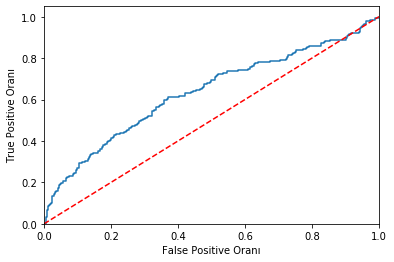

In [35]:
logit_roc_auc= roc_auc_score(y,loj_model.predict(X))
fpr, tpr, thresholds= roc_curve(y, loj_model.predict_proba(X)[:,1]) #verideki y=1 olan gözlemlerin % kaçına ulaştığımızı göstermektedir.
plt.figure()
plt.plot(fpr, tpr, label= 'AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.show()

Verinin ilk %20'sini alırsak, kötü müşterilerin %60'na ulaşılırız.

**Veri setini train-test olarak ayıralım.**

In [36]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.25, random_state=42)

In [37]:
print("Train seti Accuracy Score:" , accuracy_score(y_train,loj_model.predict(X_train)))

Train seti Accuracy Score: 0.9081295439524124


In [39]:
print(classification_report(y_train,loj_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1374
           1       0.00      0.00      0.00       139

    accuracy                           0.91      1513
   macro avg       0.45      0.50      0.48      1513
weighted avg       0.82      0.91      0.86      1513



In [38]:
print("Test seti Accuracy Score:", accuracy_score(y_test,loj_model.predict(X_test)))

Test seti Accuracy Score: 0.9227722772277228


In [40]:
y_pred=loj_model.predict(X_test)#test setindeki X'lerden y'leri tahmin ediyorum.

In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       466
           1       0.00      0.00      0.00        39

    accuracy                           0.92       505
   macro avg       0.46      0.50      0.48       505
weighted avg       0.85      0.92      0.89       505



In [42]:
cross_val_score(loj_model,X_test,y_test, cv=10).mean() 

0.922781112444978

_cross validation score değer ortalamaları accuracy'ye çok yakın demek ki;
sadece iyi sample'ler şansa denk gelmemiş iyi bir model kurulmuş._

**Train Seti için Roc Grafiği**

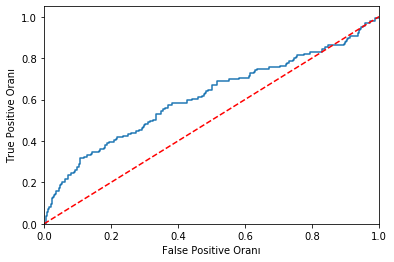

In [44]:
logit_roc_auc= roc_auc_score(y_train,loj_model.predict(X_train))
fpr, tpr, thresholds= roc_curve(y_train, loj_model.predict_proba(X_train)[:,1]) #verideki y=1 olan gözlemlerin % kaçına ulaştığımızı göstermektedir.
plt.figure()
plt.plot(fpr, tpr, label= 'AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.show()

**Test Seti için Roc Grafiği**

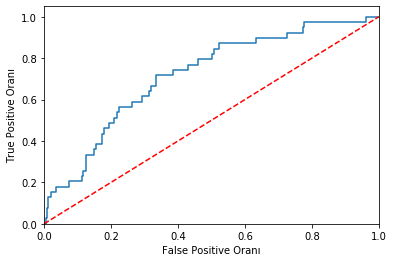

In [45]:
logit_roc_auc= roc_auc_score(y_test,loj_model.predict(X_test))
fpr, tpr, thresholds= roc_curve(y_test, loj_model.predict_proba(X_test)[:,1]) #verideki y=1 olan gözlemlerin % kaçına ulaştığımızı göstermektedir.
plt.figure()
plt.plot(fpr, tpr, label= 'AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.show()